<a href="https://colab.research.google.com/github/emilyhasson/BreadChase/blob/main/05-sql-joins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview 

Within this notebook, we cover SQL Joins, Injections, and non-interactive usage within the Jupyter notebook environment.

# Diagnostics

In [ ]:
#@title (Hidden) Diagnostic Check
import os
import sys
import pandas as pd
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf

print(f"python: {sys.version}")
print(f"pandas: {np.__version__}")
print(f"tensorflow: {tf.__version__}")
# Detect if a GPU is present
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  print(f"GPU Enabled: True")
else:
  print(f"GPU Enabled: False")

try:
  from google.colab import drive
  is_google_colab = True

  print("Notebook is on Google CoLab")
except:
  is_google_colab = False
  print("Notebook is being run locally or through another source.")


## Save a copy of this notebook!!

Before we get started, it is crucially important that you **save a copy of the notebook** to your Google Drive! Please go to: 

```
File -> Save a Copy in Drive
```



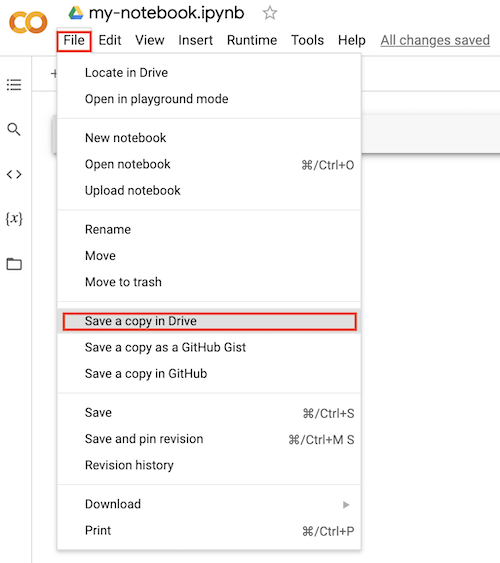

**If you _forget_ to save a copy of the notebook, all of your work will be lost when you close out of Google Colab.**

# Non-interactive Database Connections



Previously, our work focused on using an **interactive** workflow within Jupyter Notebooks. The interactive workflow is useful for quickly generating SQL queries and testing. However, more often than not, we will want to put the queries into a production environment that is **non-interactive** or is script-based.

## Connecting with `sqlite3` Python Library

Within the next case, we focus on connecting using the [`sqlite3`](https://docs.python.org/3/library/sqlite3.html) python library that is built directly into the standard python installation. That is to say, we do not need to download the `sqlite3` _python_ package as it is included with our Python installation.

We have two important terms to clarify: 

- **Connection** (abbreviated as `con` or `conn`: Communication pipeline to the database. 
   - Once done talking to the database, we close the connection.
   - This is similar to making a call via a telephone. 
- **Cursor** (abbreviated as `cur`): Iterator that holds information about the query's result set.
   -  Close those when you're done with that result set.
   - This would be the details exchanged during part of a phone conversation. 


In [ ]:
import sqlite3 

# Establish a file-backed database using SQLite3 and
# a line of communication to the database
connection = sqlite3.connect("college_departments.db")
# Frequently abbreviated as: con or conn.

# Create an database iterator to hold results.
cursor = connection.cursor()
# Frequently abbreviated as: cur


Next, let's create a table structure and populate it with some sample records.

In [ ]:
# Create and insert into the database using
# a set of queries through executescript()
cursor.executescript(""" 
    --- Create the table
    CREATE TABLE IF NOT EXISTS college_department( 
      department_id INTEGER,
      department_name VARCHAR(20), 
      department_enrollment INTEGER); 
    
    --- Populate the table
    INSERT INTO college_department VALUES (1,'STAT', 1000);
    INSERT INTO college_department VALUES (2,'CS', 5000);
    INSERT INTO college_department VALUES (3,'MATH', 2500);
    INSERT INTO college_department VALUES (4,'PSYC', 3000);
""")


At the end of each run, we're receiving the `Cursor` object back. If we wanted to see the results, we would need to use: 



In [ ]:
table_result = cursor.fetchall()
table_result

In this case, no records are being retrieved, just inserted. If we change to retrieving multiple records we could see output:

In [ ]:
print("Initial Table data:")
cursor.execute("SELECT * FROM college_department") 

In [ ]:
my_data = cursor.fetchall()
my_data

Hmm, looks like we accidentally sent data from 2018 instead of 2019. The data can be corrected using a series of `UPDATE` steps.


In [ ]:
# Change multiple enrollments
cursor.executescript("""
    UPDATE college_department set department_enrollment = 1200 where department_name = "STAT";
    UPDATE college_department set department_enrollment = 3200 where department_name = "PSYC";
    UPDATE college_department set department_enrollment = 2750 where department_name = "MATH";
    UPDATE college_department set department_enrollment = 7800 where department_name = "CS";
""")

In [ ]:
# Check the values now stored in the table
print("Post UPDATE table data:")
cursor.execute("SELECT * FROM college_department") 
print(cursor.fetchall())

Finally, we need to save the changes and propagate them back into the Database.

In [ ]:
# Save (commit) the changes 
connection.commit() 

# Close the database connection 
connection.close()

## Importing and Exporting Tables

Next, let's cover recreating a SQL Database from a `SQL` file, not a `csv` file. 

For this exploration, we'll be using the `northwind` data. This data has been "dumped" or written out of the Database in a `SQL` file. 

In [ ]:
!wget https://coatless.github.io/raw-data/northwind-dump.sql

In [ ]:
!tail northwind-dump.sql

With the data now saved to disk, we need to ingest the data by issuing each command found inside of the `dump` file to generate the database. 

In [ ]:
import sqlite3

# Establish a file-backed database using SQLite3
connection = sqlite3.connect('northwind.db')
# Frequently abbreviated as: con or conn.

# Create a connection into the database.
cursor = connection.cursor()
# Frequently abbreviated as: cur

# Import data with execute script
with open('northwind-dump.sql') as fp:
    cursor.executescript(fp.read())

# Save (commit) the changes 
connection.commit() 

# Close the database connection 
connection.close()

We can verify the database was loaded into SQLite by querying against the `sqlite_master`.

In [ ]:
# Establish a file-backed database using SQLite3
connection = sqlite3.connect('northwind.db')
# Create a connection into the database.
cursor = connection.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())
connection.close()

We can also export the entire database.

In [ ]:
import sqlite3

conn = sqlite3.connect("northwind.db")
f = open('northwind-our-dump.sql', 'w')
for line in conn.iterdump():
    f.write(f'{line}\n')
f.close()

### Your Turn: Importing Data

1. Create the **fueleconomy** database.
2. Load **common.csv** and **vehicles.csv** into the **fueleconomy** database.

Obtain the data from: 

- <https://coatless.github.io/raw-data/common.csv>
- <https://coatless.github.io/raw-data/vehicles.csv>

# Joins

Joining or merging refers to combining two different pieces of data together to form a larger data set that contains more observations, variables, or both. 

We cover naive joins that make no assumption on column relations and more structured joins that have additional assumptions.

## Naive Joins

### Ordered Naive Joins

In [ ]:
import pandas as pd 

# Same number of rows, 
# exact ordering, and 
# no repeated rows.
first_df = pd.DataFrame({
     "UID": [1, 2, 3, 4],
     "Grade": ["A", "B", "C", "A"]
})

sec_df = pd.DataFrame({
     #"UID": [1, 2, 3, 4], # Data already ordered
     "Exams": [38.4, 39.9, 40, 20.5]
}) 

# Merge the data together
merged_df = pd.concat(
  [first_df, sec_df], axis = 1, 
  ignore_index = True
)

# Or, using append()
merged_append_df = first_df.append(sec_df)

# Retrieve specific columns 
# with the same order
selected_df = pd.DataFrame({
  "UID": first_df['UID'],
  "Exams": sec_df['Exams']
}) 

selected_df

### Unordered Naive Join

In [ ]:
import pandas as pd 

# Same number of rows,
# unordered data,
# and no repeated rows.
bad_first_df = pd.DataFrame({
    "UID": [4, 3, 2, 1],
    "Grade": ["A", "C", "B", "A"]
})
bad_sec_df = pd.DataFrame({
    "UID": [2, 1, 4, 3], 
    "Exam":  [39.9, 38.4, 20.5, 40]
}) 

# That doesn't look right… 
bad_merged_df = pd.concat(
  [bad_first_df, bad_sec_df], axis = 1, 
  ignore_index = True
) 

bad_merged_df

### Ordering for Naive Joins

In [ ]:
# Same number of rows, exact ordering,
# no repeated rows.
bad_first_df = pd.DataFrame({
    "UID": [4, 3, 2, 1],
    "Grade": ["A", "C", "B", "A"]
})
bad_sec_df = pd.DataFrame({
    "UID": [2, 1, 4, 3], 
    "Exam":  [39.9, 38.4, 20.5, 40]
}) 

# Order data frames
ordered_first_df = bad_first_df.sort_values(
  by = "UID", ascending = True, 
  ignore_index = True
)
ordered_sec_df = bad_sec_df.sort_values(
  by = "UID", ascending = True, 
  ignore_index = True
)

# Combine the ordered data frames
ordered_merged_df = pd.concat(
  [ ordered_first_df, ordered_sec_df["Exam"] ],
  axis = 1, ignore_index = True
)

ordered_merged_df

## Joins for Uneven or Unordered Data

In the previous section on joining data, we encountered errors when we performed joins that did not form a strict relationship with the jointly shared column between data sets. We introduce an showcase a way to performing improved joins that respect the column relationship between tables using both Pandas and SQL.

| Merge method | SQL Join Name      | Description                                       |
| ------------ | ------------------ | ------------------------------------------------- |
| `inner`      | `INNER JOIN`       | Use intersection of keys from both frames |
| `outer`      | `FULL OUTER JOIN`  | Use union of keys from both frames                |
| `left`       | `LEFT OUTER JOIN`  | Use keys from left frame only                     |
| `right`      | `RIGHT OUTER JOIN` | Use keys from right frame only                    |


In [ ]:
X = pd.DataFrame({
    "Key": [1, 2, 3] ,
    "Points": [90, 84, 75]
})
display(X)

In [ ]:
Y = pd.DataFrame({
    "Key": [1, 2, 4],
    "Letter": ["A", "B", "D"]
})

display(Y)

We'll next move the data into a temporary SQL database.

In [ ]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///join-examples.db', echo=False)

# Create the X table in the sqlite database
X.to_sql('X', index = False, if_exists = 'replace', con=engine)

# Create the Y table in the sqlite database
Y.to_sql('Y', index = False, if_exists = 'replace', con=engine)

Next, let's view the SQL directly by querying with Pandas

In [ ]:
pd.read_sql('SELECT * FROM X', engine)

In [ ]:
pd.read_sql('SELECT * FROM Y', engine)

Lastly, let's switch over to using an interactive workflow... 

In [ ]:
%load_ext sql

In [ ]:
%sql sqlite:///join-examples.db

### Mutating Joins

Mutating joins will add new variables to one table from matching observations in another.

#### Inner Join

Acquires the set of values that are in both `Table X` and `Table Y`.

In [ ]:
pd.merge(X, Y, on = "Key", how = "inner")

In [ ]:
%%sql

SELECT 
X.Key as Key, 
Points,
Y.Letter as Letter
FROM X
INNER JOIN Y
ON X.Key = Y.Key;


#### Left Join

Acquires the set of complete values in Table `X` paired with the values in Table `Y` if available. If the values do not exist, the left side will have `np.nan` values substituted.

In [ ]:
pd.merge(X, Y, on = "Key", how = "left")

In [ ]:
%%sql 

SELECT 
X.Key as Key, 
Points,
Y.Letter as Letter
FROM X
LEFT JOIN Y
ON X.Key = Y.Key;


#### Right Join

Acquires the set of complete values in `Table Y` paired with the values in `Table X` if available. If the values do not exist, the right side will have `np.nan` values substituted.


In [ ]:
pd.merge(X, Y, on = "Key", how = "right")

```sql
SELECT 
X.Key as Key, 
Points,
Y.Letter as Letter
FROM X
RIGHT JOIN Y
ON X.Key = Y.Key;
```

```sh
(sqlite3.OperationalError) RIGHT and FULL OUTER JOINs are not currently supported
```

However, `LEFT JOIN` is supported! If we reverse the Table positions, then we can perform the desired operation

In [ ]:
%%sql 

SELECT 
Y.Key as Key, --- Change # 1
Points,
Y.Letter as Letter
FROM Y        --- Change # 2
LEFT JOIN X   --- Change # 3
ON X.Key = Y.Key;


#### Full (Outer) Join

Acquires the set of all values in Table `X` and Table `Y`, regardless of whether they have values that exist in both tables. If the values do not exist, the missing side will have `np.nan` values substituted.

In [ ]:
pd.merge(X, Y, on = "Key", how = "outer")

If we attempt something similar with SQLite, we'll run into an issue: 

```sql
%%sql

SELECT 
X.Key as Key, 
Points,
Y.Letter as Letter
FROM X
FULL OUTER JOIN Y
ON X.Key = Y.Key;
```

```
(sqlite3.OperationalError) RIGHT and FULL OUTER JOINs are not currently supported
```

We can get around the SQLite limitation by using a similar trick to what we needed to do for the `RIGHT OUTER JOIN`. However, we'll need to:

1. Query like normal
2. Perform a left join
3. Allow duplicate results to persist using the `UNION ALL` operator
4. Write a second `SELECT` statement 
5. Switch Table order to perform a `RIGHT JOIN` using a `LEFT JOIN`.
6. Subset the second `SELECT` with a `WHERE` clause that removes rows in the first table. 

In [ ]:
%%sql

SELECT 
X.Key as Key, 
X.Points as Points,
Y.Letter as Letter
FROM X
LEFT JOIN Y USING(Key)  --- Change # 1
UNION ALL               --- Change # 2
SELECT 
Y.Key,                  --- Change # 3
X.Points,
Y.Letter
FROM Y
LEFT JOIN X USING(Key)  --- Change # 4
WHERE X.Key IS NULL;    --- Change # 5

### Filtering Joins

Filtering joins will filter observations from one table based on whether or not they match an observation in the other table.


#### Anti-join

Purges the set of complete values in Table `X` that have a matching key in Table `Y`.

In [ ]:
def anti_join(x, y, on):
  return x[~x[on].isin(y[on])]

anti_join(X, Y, on = "Key")

In [ ]:
%%sql 

SELECT X.Key as Key,
       X.Points as Points
FROM X
LEFT JOIN Y
  ON X.Key = Y.Key
WHERE Y.Key is NULL


#### Semi-join

Acquires the set of complete values in Table `X` that have a matching key in Table `Y`.

In [ ]:
def semi_join(x, y, on):
  return x[x[on].isin(y[on])]

semi_join(X, Y, "Key")

In [ ]:
%%sql 

SELECT *
FROM X
WHERE Key IN (
  SELECT Key
  FROM Y
)

In [ ]:
%%sql 

-- EXISTS
SELECT *
FROM X
WHERE EXISTS (
  SELECT 1
  FROM Y
  WHERE X.Key = Y.Key
)

### Your Turn: Joining Fueleconomy

1. Recall the fueleconomy we previously created.
2. Determine the appropriate keys between common and vehicles tables.
3. Perform a semi join based on common and vehicles tables shared key.

In [ ]:
# Code here

### Set Operations

Set operations will treat observations as if they were elements in a set. 


In [ ]:
import numpy as np 

x = {-8, 0, 2, 1, 23, np.nan}
y = {-8, 3, 1, np.nan, 2, 10}

Find the union of all elements between sets.

In [ ]:
x.union(y)          # X or Y (Full)

Find the intersection or common elements between sets.

In [ ]:
x.intersection(y)    # X and Y (Intersect)

Difference between sets

In [ ]:
x - y        # Y - X  (Anti-join)

Difference between sets

In [ ]:
y - x        # X - Y  (Anti-join)

Check strict set equality

In [ ]:
x == y    # X = Y

Check for whether elements in `x` are found in `y`.

In [ ]:
[i in y for i in x] # X in Y (Intersect)

# Entity-Relationship Diagrams (ERD)



```sql
CREATE TABLE movie (
 id integer,
 title text,
 year integer,
 PRIMARY KEY (ID)
);
```

## Example: Lahman Data

The [Lahman data set](http://www.seanlahman.com/baseball-archive/statistics/) is compiled yearly into a SQLite-variant.

<https://github.com/jknecht/baseball-archive-sqlite>



In [ ]:
!wget https://coatless.github.io/raw-data/lahman2019.sqlite

We'll switch back into interactivate mode to explore the data. 

In [ ]:
%load_ext sql

In [ ]:
%sql sqlite:///lahman2019.sqlite

Let's take a look at the available tables available inside of Lahman.

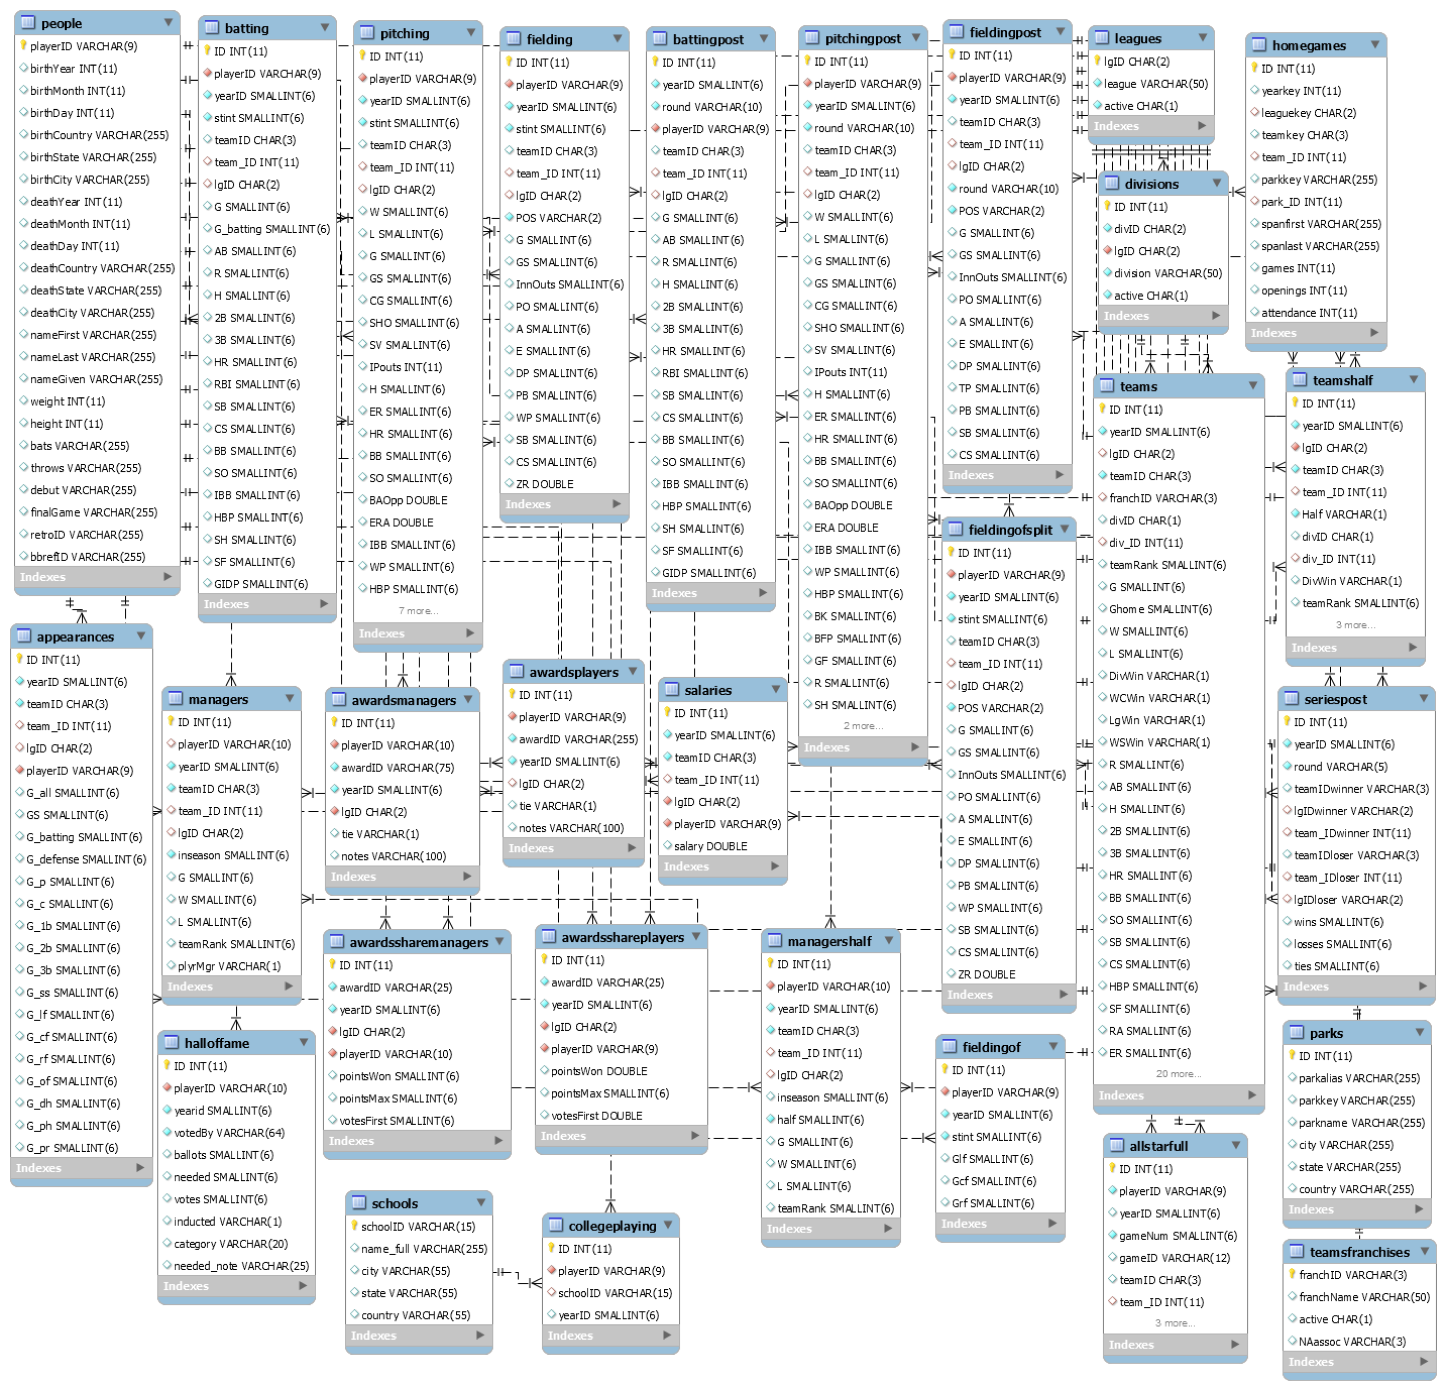

### View All Tables 

How can we see the names of all tables in the Lahman database if we did not have an ER Diagram? 

In [ ]:
%%sql 

SELECT name FROM sqlite_master WHERE type='table'

### View Table Schema 

Let's peak into the `batting` table schema:

In [ ]:
%%sql 

PRAGMA table_info(batting)

### SQL Queries 
We could then build queries such as the average number of home runs and hits.

In [ ]:
%%sql 
SELECT 
AVG(HR) as avg_hr,
AVG(H) as avg_h
FROM batting

We could apply techniques to view the same information by team and year.

In [ ]:
%%sql 
SELECT teamID, yearID, AVG(HR) as avg_hr, AVG(H) as avg_h
FROM batting
WHERE yearID == 2018 OR yearID == 2019
GROUP BY teamID, yearID
ORDER BY AVG_HR DESC
LIMIT 15

We could specify a single player and look at the arc of their career. 

In [ ]:
%%sql 

SELECT playerID, HR, yearID
FROM Batting 
WHERE playerID = "barkele01"

Or, obtain a list of where the players played in College.

In [ ]:
%%sql 
SELECT *
FROM collegeplaying
GROUP BY playerID
HAVING yearID == max(YearID)
ORDER BY yearID DESC

We could even identify players born in the USA within the 1990's decade.


In [ ]:
%%sql 
SELECT nameGiven as Given, nameLast Last, birthYear AS born, birthCountry as Place
FROM people
WHERE birthCountry == "USA" AND birthYear LIKE "199%"

### Joining Queries

By performing a `JOIN`, which performs an `INNER JOIN` by default, we could see a player's performance alongside of their salary.

However, joining on a single key yields odd results...


In [ ]:
%%sql 
SELECT playerID, HR, salary
FROM Batting JOIN Salaries USING(playerID)
LIMIT 10

Repeating this `JOIN` statement using two keys performs much better:


In [ ]:
%%sql 
SELECT yearID, playerID, HR, salary
FROM Batting JOIN Salaries USING(yearID, playerID)
LIMIT 10


We could be more explicit using `INNER JOIN ... ON ...`

In [ ]:
%%sql 
SELECT Salaries.yearID, Salaries.playerID, HR, salary
FROM Batting 
INNER JOIN Salaries ON 
Salaries.playerID = Batting.playerID AND
Salaries.yearID = Batting.yearID
LIMIT 10

Notice that here was are specifically stating what table we are retrieving a field from.


Or, we could list the player by the number of "Runs Batted In" (RBI) over the last 10 years. 

In [ ]:
%%sql 

SELECT p.nameFirst as First, p.nameLast as Last, sum(RBI) as RBI_TOTAL
FROM batting b
INNER JOIN people p ON b.playerID = p.playerID 
WHERE yearID >= 2010
GROUP BY b.playerID
HAVING RBI_TOTAL >= 500
ORDER BY RBI_TOTAL DESC

We could even approach more complicated joins by searching the database for the allstar players! 

In [ ]:
%%sql 
SELECT nameFirst, nameLast, hof.yearid as induction_year, count(asf.yearID) AS allstar_appearances
FROM halloffame as hof
JOIN people USING (playerID)
LEFT JOIN allstarfull as asf USING (playerID)
WHERE inducted='Y' and category='Player'
GROUP BY playerID, nameFirst, nameLast
ORDER BY allstar_appearances DESC

### Subquery

We can merge two queries together and embed them inside of a join.

In [ ]:
%%sql 
SELECT aps.playerID playerID, aps.yearID as year, lgID as league, schoolID
FROM awardsplayers aps
LEFT JOIN 
  (SELECT *  -- Final College Attended
    FROM CollegePlaying
    GROUP BY playerID
    HAVING yearID == max(YearID)
  ) c
ON c.playerID = aps.playerID
WHERE aps.awardID = "Hank Aaron Award"

We could obtain further insights by obtaining a count of the award.

In [ ]:
%%sql 
SELECT schoolID, count(c.playerID) as Hank_Aaron_Awards
FROM awardsplayers ap
LEFT JOIN 
  (SELECT *  --Last College Attended
    FROM CollegePlaying
    GROUP BY playerID
    HAVING yearID == max(yearID)
  ) c
ON c.playerID = ap.playerID
WHERE awardID = "Hank Aaron Award" AND schoolID IS NOT NULL
GROUP BY schoolID
HAVING Hank_Aaron_Awards > 1
ORDER BY Hank_Aaron_Awards DESC


### Your Turn: Some SQL Queries

Retrieve the salaries of the top 5 Average Home Run (HR) hitting players across the years. 

In [ ]:
%%sql 

SELECT 
yearID, playerID, HR, Salary 
FROM Batting
JOIN Salaries USING(yearID, playerID)

In [ ]:
%%sql 
--- Fill me in!


Determine all the players born in the State of Illinois who played in 2019

_Hint_: The `batting` and `people` tables will be useful.

In [ ]:
%%sql 

--- Fill me in!

Find all distinct awards in the `awardplayers` table

In [ ]:
%%sql 

--- Fill me in!

Finding all "Rookie of the Year Awards" in the `awardplayers` Table.

In [ ]:
%%sql 

--- Fill me in!

# SQL Injections

Before we wrap up this part of the SQL unit, we do need to revisit the variable substitution technique to address the famous [XKCD #327](https://xkcd.com/327/).

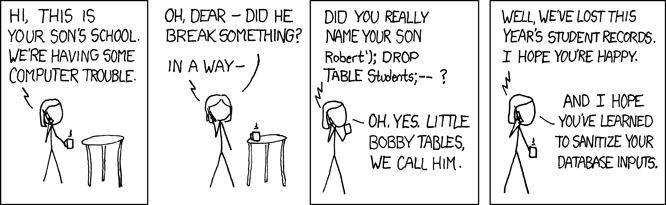

## Construct a Database

We'll next build the hypothetical table that the school likely used to store student information.

In [ ]:
import sqlite3

# Establish a file-backed database using SQLite3 and
# a line of communication to the database
connection = sqlite3.connect("Students.db")
# Frequently abbreviated as: con or conn.

# Create a database iterator to hold results.
cursor = connection.cursor()
# Frequently abbreviated as: cur

# Create a table called Students with minimal attributes
cursor.execute("CREATE TABLE Students (Name TEXT, Age INT)")
# Save changes
connection.commit()

# Insert records from Pythoon into the Database
data = [("Robert", 13), ("Lexi", 15), ("Ridha", 16)]
cursor.executemany("INSERT INTO Students VALUES (?,?)", data)

# Save changes
connection.commit()


Next, let's do a couple of test queries to see if the database was established correctly.

In [ ]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

In [ ]:
cursor.execute("SELECT * FROM Students")
result = cursor.fetchall()
print(result)

Finally, let's close the connection.

In [ ]:
# Close connection
connection.close()

## Backup Database (Export Data)

Now that we've confirmed the database is operational, we probably should make a backup. Just as before, we can backup the data by using:

In [ ]:
import sqlite3

conn = sqlite3.connect("Students.db")
f = open('Students-dump.sql', 'w')
for line in conn.iterdump():
    f.write(f'{line}\n')
f.close()

We can view the first line of the back up by using `head` inside of `shell`.

In [ ]:
!head Students-dump.sql

## Dynamic Query Injection

With the database now backed up, let's see one observation using a query that the school may have used

In [ ]:
# Re-establish connection
connection = sqlite3.connect("Students.db")
cursor = connection.cursor()

Obtain all observations for a student named `Robert`.

In [ ]:
cursor.execute("SELECT * FROM Students WHERE Name='Robert'")
result = cursor.fetchall()
print(result)

So, if we put this query in production, our assumption will be that only **one** student record can be retrieved at a time.

However, we're no longer wearing a white hat, we've specifically donned a black hat so that we can be a bit mischievous. 

For our next step, we're going to use a dynamic variable to replace the student's name, but our name will mirror what the Mom gave to her child:

```
Robert'; DROP TABLE Students;--
```

**Note:** We are not querying against the database. We are showing the resulting query that the happens after performing the variable substitution.

In [ ]:
Name = "Robert'; DROP TABLE Students;--"
print(f"SELECT * FROM Students WHERE Name='{Name}'")

We can see from the query that the extra `'` meant to quote the name has now been commented out. Moreover, in the place of the student's name, we now have an additional command: 

```sql
SELECT * FROM Students WHERE Name='Robert';
DROP TABLE Students; -- Additional command
```

Let's launch the query on the data:

In [ ]:
Name = "Robert'; DROP TABLE Students;--"
cursor.executescript("SELECT * FROM students WHERE Name='%s'" % Name)

result = cursor.fetchall()
print(result)

Huh, there isn't a student named as `Robert` in the `Students` table now? That doesn't seem right... We probably should check to see if `Students` are still present in the database.

In [ ]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

So, we've inadvertently allowed for the database to be wiped out completely... I hope our backups work! 

## Restore from Backup

Thankfully, we have a SQL dump file that we can use to restore the database. Though, as our example is a bit contrieved, the alternative is just re-using existing values. 

In [ ]:
import sqlite3

# Establish a file-backed database using SQLite3
connection = sqlite3.connect('Students.db')
# Frequently abbreviated as: con or conn.

# Create a connection into the database.
cursor = connection.cursor()
# Frequently abbreviated as: cur

# Import data with execute script
with open('Students-dump.sql') as fp:
    cursor.executescript(fp.read())

# Save (commit) the changes 
connection.commit() 

# Close the database connection 
connection.close()

## Protecting Against Injections with Parameterized Input

To protect against SQL Injections, we just follow the advice and seek to use either: `qmark`-style or `named`-style:

```python
## q-mark style
cur.execute(
  "SELECT * FROM table WHERE clause=(?)", 
  (480,)
)

## named style
cur.execute(
  "SELECT * FROM table WHERE clause=:value", 
  {"value": 480}
)
```

Let's re-establish a connection into the database:

In [ ]:
# Establish a file-backed database using SQLite3
connection = sqlite3.connect('Students.db')
# Frequently abbreviated as: con or conn.

# Create a connection into the database.
cursor = connection.cursor()
# Frequently abbreviated as: cur

Next, let's try out the different parameterized input options. 

#### Q-mark

In [ ]:
student_name = ("Robert'; DROP TABLE Students;--", )
cursor.execute(
    "SELECT * FROM Students WHERE Name=(?)", student_name   
)

result = cursor.fetchall()
print(result)

In [ ]:
cursor.execute(
    "SELECT * FROM Students"   
)

result = cursor.fetchall()
print(result)

### Named-entity

In [ ]:
student_name = {"Name": "Robert'; DROP TABLE Students;--"}
cursor.execute(
    "SELECT * FROM Students WHERE Name=':Name'", student_name   
)

result = cursor.fetchall()
print(result)

In [ ]:
cursor.execute(
    "SELECT * FROM Students"   
)

result = cursor.fetchall()
print(result)